In [1]:
import numpy as np
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
import matplotlib.image as img
import librosa
from IPython.display import Audio, display, clear_output
from ipywidgets import widgets
%matplotlib inline

In [2]:
y, sr = librosa.load('data/ambient-roald-velden-morning-glow-62s-92s-44100hz-256k-16bit.wav', sr=44100)
display(Audio(y, rate=44100))

len(y), sr

1 (2646000,)
2 (2, 1323000)
3 (1323000,)
4 (1323000,)


(1323000, 44100)

## Time series

(0, 1024)

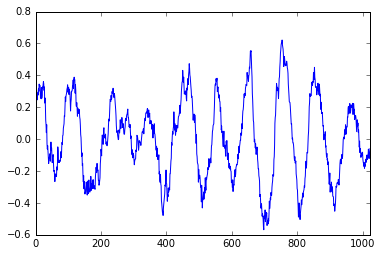

In [3]:
plt.plot(y[:1024])
plt.xlim(0, 1024)

## FFT with scipy

([<matplotlib.axis.XTick at 0x1183c8d30>,
 <a list of 5 Text xticklabel objects>)

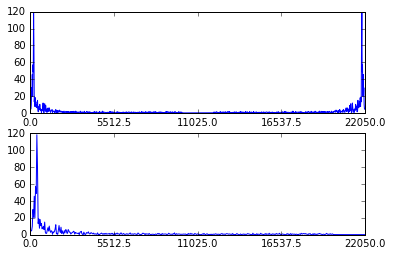

In [4]:
D = np.abs(fftpack.fft(y[:1024]))

# Plain
plt.subplot(211)
plt.plot(D)
plt.xlim(0, 1024)
plt.xticks(np.linspace(0, len(D), 5), np.linspace(0, 44100 / 2, 5))

# Nyquist
plt.subplot(212)
D_half = D[:int(1024 / 2) + 1]
plt.plot(D_half)
plt.xlim(0, len(D_half))
plt.xticks(np.linspace(0, len(D_half), 5), np.linspace(0, 44100 / 2, 5))

## STFT with fftpack

In [5]:
# TODO

## STFT and plotting with librosa

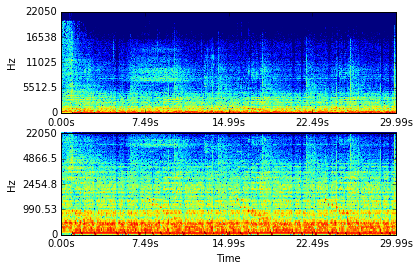

In [6]:
D = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))

plt.subplot(211)
librosa.display.specshow(librosa.logamplitude(D ** 2, ref_power=np.max), sr=44100, x_axis='time', y_axis='linear', cmap=None)

plt.subplot(212)
librosa.display.specshow(librosa.core.logamplitude(D ** 2,  ref_power=np.max) , sr=44100, x_axis='time', y_axis='log', cmap=None)

## STFT with librosa, plotting with matplotlib

([<matplotlib.axis.YTick at 0x107d54390>,
 <a list of 5 Text yticklabel objects>)

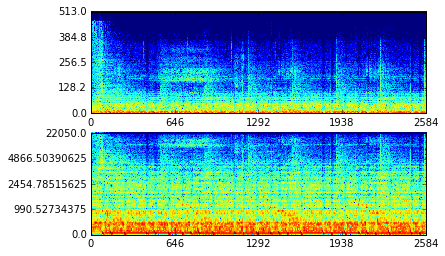

In [7]:
def __log_scale(n):
    logn = np.log2(n)
    y = n * (1 - np.logspace(-logn, 0, n, base=2, endpoint=True))[::-1]
    y = y.astype(int)

    y_inv = np.arange(len(y))
    for i in range(len(y)-1):
        y_inv[y[i]:y[i+1]] = i

    return y, y_inv


D = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))
rows, cols = np.shape(D)

fig = plt.figure()

# linear scale
ax1 = fig.add_subplot(211)
im_phantom1 = img.NonUniformImage(ax1, extent=(0, 1, 0, 1))
im_phantom1.set_data(np.arange(cols), np.arange(rows), librosa.logamplitude(D ** 2, ref_power=np.max))
ax1.images.append(im_phantom1)
plt.xticks(np.linspace(0, cols, 5))
plt.yticks(np.linspace(0, rows, 5))

# log scale
ax2 = fig.add_subplot(212)
log_y, log_y_inv = __log_scale(rows)
im_phantom2 = img.NonUniformImage(ax2, extent=(0, 1, 0, 1))
im_phantom2.set_data(np.arange(cols), log_y, librosa.logamplitude(D ** 2, ref_power=np.max))
ax2.images.append(im_phantom2)
plt.xticks(np.linspace(0, cols, 5))
plt.yticks(np.linspace(0, rows - 1, 5), np.linspace(0, sr / 2, rows)[log_y_inv[np.linspace(0, rows - 1, 5).astype(int)]])

## CQT and plotting with librosa

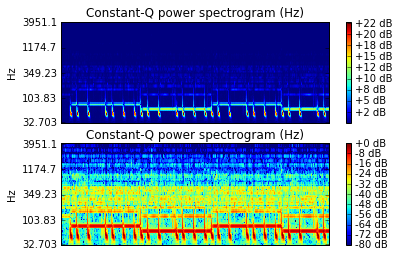

In [8]:
CQT = np.abs(librosa.cqt(y, sr=44100, real=False))

plt.subplot(211)
librosa.display.specshow(CQT, y_axis='cqt_hz', cmap=None)
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (Hz)')

plt.subplot(212)
librosa.display.specshow(librosa.logamplitude(CQT ** 2,  ref_power=np.max), y_axis='cqt_hz', cmap=None)
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrogram (Hz)')

## Decomposing with librosa

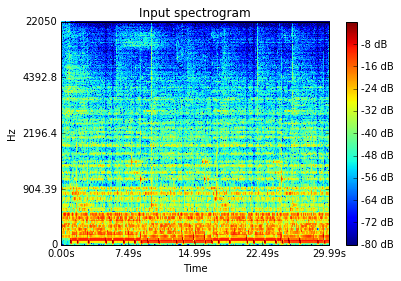

In [9]:
S = np.abs(librosa.stft(y))
comps, acts = librosa.decompose.decompose(S, n_components=8)
np.shape(comps)
librosa.display.specshow(librosa.logamplitude(S**2, ref_power=np.max),
                         y_axis='log', x_axis='time', cmap=None, sr=44100)
plt.title('Input spectrogram')
plt.colorbar(format='%+2.0f dB')

## HPSS with librosa

In [10]:
D = librosa.stft(y)

def show_specs(H, P):
    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.logamplitude(np.abs(H)**2, ref_power=np.max), sr=sr, y_axis='log', cmap=None)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Harmonic power spectrogram')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.logamplitude(np.abs(P)**2, ref_power=np.max), sr=sr, y_axis='log', cmap=None)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Percussive power spectrogram')


def transform(b):
    H, P = librosa.decompose.hpss(D, kernel_size=(h_slider.value, p_slider.value))
    y_h = librosa.istft(H)
    y_p = librosa.istft(P)
    orig_audio = Audio(y, rate=44100)
    h_audio = Audio(y_h, rate=44100)
    p_audio = Audio(y_p, rate=44100)
    
    clear_output(wait=True)
    
    print('original')
    display(orig_audio)
    print('harmonic with size_H={}, size_P={}'.format(h_slider.value, p_slider.value))
    display(h_audio)
    print('harmonic with size_H={}, size_P={}'.format(h_slider.value, p_slider.value))
    display(p_audio)
    
    show_specs(H, P)


orig_audio = Audio(y, rate=44100)
display(orig_audio)
container = widgets.Box()
tr_button = widgets.Button(description='Transform')
tr_button.on_click(transform)
buttons = [
    tr_button
]

h_slider = widgets.IntSlider(description='size_H', min=1, max=100, value=31)
p_slider = widgets.IntSlider(description='size_P', min=1, max=100, value=31)
display(h_slider, p_slider)
container.children = buttons
display(container)